![A soccer pitch for an international match.](soccer-pitch.jpg)

***Scenario:*** You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question we are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [1]:
import pandas as pd

# read data
df_men_socc = pd.read_csv('./data/men_results.csv')
df_women_socc = pd.read_csv('./data/women_results.csv')
print(df_men_socc.columns)
print(df_women_socc.columns)

Index(['Unnamed: 0', 'date', 'home_team', 'away_team', 'home_score',
       'away_score', 'tournament'],
      dtype='object')
Index(['Unnamed: 0', 'date', 'home_team', 'away_team', 'home_score',
       'away_score', 'tournament'],
      dtype='object')


In [2]:
# drop the redundant index column
df_men_socc.drop('Unnamed: 0', axis='columns', inplace=True)
df_women_socc.drop('Unnamed: 0', axis='columns', inplace=True)
# add gender column so we can combine
df_men_socc['gender'] = "men"
df_women_socc['gender'] = "women"
# combine
df_all = pd.concat([df_men_socc, df_women_socc], ignore_index=True)
print(f"shape BEFORE removing qualifier matches: {df_all.shape}")
df_all.head()

shape BEFORE removing qualifier matches: (49237, 7)


,date,home_team,away_team,home_score,away_score,tournament,gender
0,1872-11-30,Scotland,England,0,0,Friendly,men
1,1873-03-08,England,Scotland,4,2,Friendly,men
2,1874-03-07,Scotland,England,2,1,Friendly,men
3,1875-03-06,England,Scotland,2,2,Friendly,men
4,1876-03-04,Scotland,England,3,0,Friendly,men


In [3]:
# remove all rows before 2002-01-01
df_all = df_all.loc[df_all['date'] >= '2002-01-01'].copy()
print(f"shape AFTER removing qualifier matches: {df_all.shape}")
df_all.head()

shape AFTER removing qualifier matches: (23009, 7)


,date,home_team,away_team,home_score,away_score,tournament,gender
24863,2002-01-04,Bahrain,Finland,0,2,Prime Minister's Cup,men
24864,2002-01-04,Egypt,Ghana,2,0,Friendly,men
24865,2002-01-04,Martinique,Guadeloupe,1,3,Friendly,men
24866,2002-01-05,Albania,North Macedonia,0,0,Prime Minister's Cup,men
24867,2002-01-05,Kuwait,Zimbabwe,3,0,Friendly,men


In [4]:
# add column of total goals scored needed for comparison
df_all["total_goals"] = df_all['home_score'] + df_all['away_score']

print(df_all[df_all["gender"] == "men"].describe(), '\n')    # 19490
print(df_all[df_all["gender"] == "women"].describe(), '\n')  #  3519

df_all.head()

         home_score    away_score   total_goals
count  19490.000000  19490.000000  19490.000000
mean       1.613905      1.099795      2.713699
std        1.655043      1.346312      1.939837
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      1.000000
50%        1.000000      1.000000      2.000000
75%        2.000000      2.000000      4.000000
max       21.000000     21.000000     22.000000 

        home_score   away_score  total_goals
count  3519.000000  3519.000000  3519.000000
mean      2.094913     1.460358     3.555271
std       2.437992     1.992326     2.578996
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     2.000000
50%       1.000000     1.000000     3.000000
75%       3.000000     2.000000     5.000000
max      21.000000    24.000000    26.000000 



,date,home_team,away_team,home_score,away_score,tournament,gender,total_goals
24863,2002-01-04,Bahrain,Finland,0,2,Prime Minister's Cup,men,2
24864,2002-01-04,Egypt,Ghana,2,0,Friendly,men,2
24865,2002-01-04,Martinique,Guadeloupe,1,3,Friendly,men,4
24866,2002-01-05,Albania,North Macedonia,0,0,Prime Minister's Cup,men,0
24867,2002-01-05,Kuwait,Zimbabwe,3,0,Friendly,men,3


In [9]:
total_men_women_match_combinations = 19490 * 3519
print(f"total (men, women) match combinations: {total_men_women_match_combinations}")

total (men, women) match combinations: 68585310


68585310
68585310


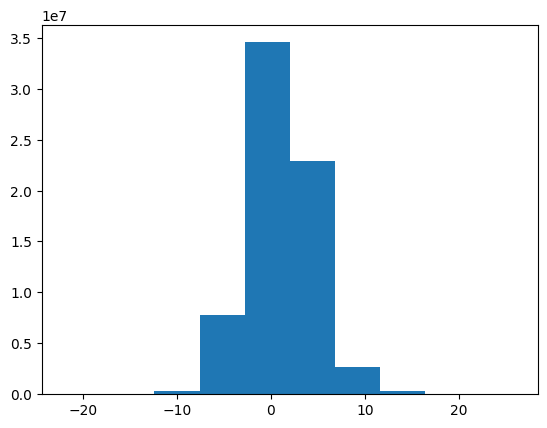

In [18]:
import matplotlib.pyplot as plt
import itertools
total_women_men_match_scores = tuple(
    itertools.product(
        df_all[df_all["gender"] == "women"]['total_goals'],
        df_all[df_all["gender"] == "men"]['total_goals']
    )
)

score_diffs = [x[0] - x[1] for x in total_women_men_match_scores]

print(len(total_men_women_match_scores))  # should be 68585310, check
print(len(score_diffs))                   # should be 68585310, check

# What the distribution of these diff look like?
fig, ax = plt.subplots()
ax.hist(score_diffs,
        label="score diffs")
plt.show()

## Goal distributions

Before selecting a test to test our hypothesis, let's looks at the shape of the total goals distributions. It is not obvious from the visual below that women matches score more goals on average. We can also see that these distributions clearlly are **not** normal which we knew in advance to be case because it is a discrete distribution with the left side being bounded by zero (i.e. can not go below zero).

Because of the data is not normally distributed, a non-parametric test such as the ***Mann-Whitney U Test*** makes sense here.

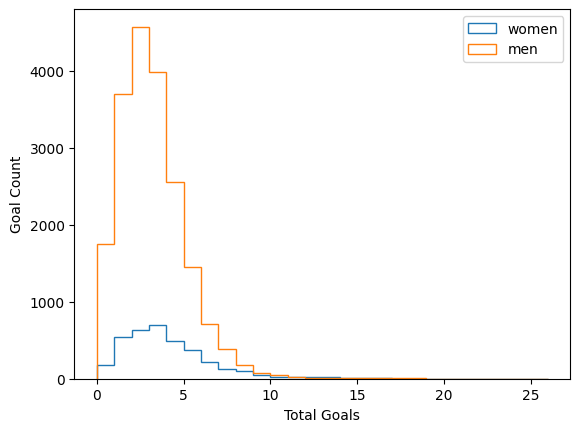

In [7]:
import seaborn as sns

goal_bins = range(27) #list(range(16))

fig, ax = plt.subplots()
ax.hist(df_all[df_all['gender'] == 'women']['total_goals'],
        label="women", bins=goal_bins, histtype="step")
ax.hist(df_all[df_all['gender'] == 'men']['total_goals'],
        label="men", bins=goal_bins, histtype="step")
ax.set_xlabel("Total Goals")
ax.set_ylabel("Goal Count")
ax.legend()
# plt.xlim(0, 15)
plt.show()

In [8]:
from scipy.stats import mannwhitneyu

alpha = 0.10

stat, p_val = mannwhitneyu(
    df_all[df_all['gender'] == 'women']['total_goals'],
    df_all[df_all['gender'] == 'men']['total_goals'],
    alternative='greater'  # HA: women score more goals
)

def test_hypothesis(alpha, p_val):
    if p_val < alpha:
        result = "reject"
    else:
        result = "fail to reject"

    return {"p_val": p_val, "result": result}

result_dict = test_hypothesis(alpha, p_val)

print(f"Mann-Whitney U test p-value: {result_dict['p_val']}")
print(f"At alpha = {alpha}, we {result_dict['result']} the null hypothesis that means are the same in favor of the alternative hypothesis")

Mann-Whitney U test p-value: 7.703140811178407e-75
At alpha = 0.1, we reject the null hypothesis that means are the same in favor of the alternative hypothesis


In [ ]:
df_all['date'].min(), df_all['date'].max()